## MNIST classification

In this notebook we tackle the perhaps most well known problem in all of machine learning, classifying hand-written digits.

The particular dataset we will use is the MNIST (Modified National Institute of Standards and Technology)
The digits are 28x28 pixel images that look somewhat like this:

![](https://user-images.githubusercontent.com/2202312/32365318-b0ccc44a-c079-11e7-8fb1-6b1566c0bdc4.png)

Each digit has been hand classified, e.g. for the above 9-7-0-9-0-...

Our task is to teach a machine to perform this classification, i.e. we want to find a function $\mathcal{T}_\theta$ such that

| | |
|-|-|
|$\mathcal{T}_\theta$(|<img align="center" src="https://user-images.githubusercontent.com/2202312/33177374-b134e572-d062-11e7-87c7-0574c6f5bee9.png" width="28"/>|) = 4|

**Note:** This notebook is a condensed version of the [tensorflow notebook](part2_classification.ipynb). For full details, check the explanations there.

# Import dependencies

This should run without errors if all dependencies are installed properly.

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import datasets, transforms

# PyTorch

This variant of the exercise uses [pytorch](http://pytorch.org/), the main competitor to tensorflow in the field of deep learning. It is developed by Facebook.


### Execution
The main difference to tensorflow is the *define-by-run* principle. In contrast to tensorflow's indirect way of first running operations on placeholders and then feeding the placeholders with data, pytorch runs computations immediately when executing a command.

This approach is much easier to grasp in the beginning since it looks much more like regular Python code. Furthermore, debugging is much simpler since parts of a network can be run separately for testing, which is not easily doable with tensorflow. There are possible downsides, most significantly the lack of opportunity for optimization of networks (merge nodes, simplify steps based on rules etc.). In theory, this should give tensorflow an advantage in execution speed. However, this advantage does not show in practice.

### Batched computation
This works like in tensorflow: the first axis is the batch axis.


### Channels
One notable difference between pytorch and tensorflow is the placement of the channel axis: In pytorch, the axes are `[BATCH, CHANNEL, ...]`, whereas tensorflow uses `[BATCH, ..., CHANNEL]`.

# Loading the MNIST data

Pytorch has a nice library for getting and transforming data, called [`torchvision`](https://github.com/pytorch/vision). It can be used with `DataLoader` objects that are iterators, like so:

    dataset = torchvision.datasets.MNIST(...)
    data_loader = torch.util.data.DataLoader(dataset, batch_size=50)
    for batch_idx, (images, labels) in enumerate(data_loader):
        # Do stuff with the images and labels.
        # `images` is a (50, 1, 28, 28) FloatTensor, and
        # `labels` a (50, 1, 1) LongTensor.

We load the MNIST dataset and use some normalization transform as well as conversion to pytorch `Tensor`:

In [2]:
# Load training and test data (from the official MNIST example,
# https://github.com/pytorch/examples/blob/master/mnist/main.py)
trafo = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
dset_train = datasets.MNIST('./data', train=True, download=True, transform=trafo)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=50, shuffle=True)

dset_test = datasets.MNIST('./data', train=False, transform=trafo)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=50, shuffle=True)

Showing an example image:

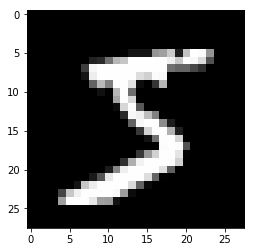

In [3]:
img = train_loader.dataset[0][0]
plt.imshow(img.squeeze(), cmap='Greys_r')

# Multilayer Perceptron

We define an MLP in pytorch by making a new class `MLP` as follows:

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.lin1 = nn.Linear(28 * 28, 128)
        self.lin2 = nn.Linear(128, 32)
        self.lin3 = nn.Linear(32, 10)


    def forward(self, x):
        x = F.relu(self.lin1(x.view(-1, 28 * 28)))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return F.log_softmax(x, dim=1)

These is the recipe we follow:

- Subclass `nn.Module` by writing `class MLP(nn.Module)`. This signals to pytorch that this is a neural network with parameters that should be optimized.

- Write an `__init__` method that initializes a new class instance right after it is created. Creation and initialization both happen in one step when we later run `model = MLP()`.
  In this `__init__` method,
  - run the initializer of the parent class by invoking `super(MLP, self).__init__()`. This is a necessary step for pytorch's internal bookkeeping;
  - register any layers that have parameters. This includes `Linear` (= fully connected) layers, convolutional layers etc. As activation we use the ReLU nonlinearity that has no parameters, so we can skip it here.
    Our layers map from input size (28 * 28) to 128, then to 32, and then to 10 (the class probabilities).
    
- Implement the `forward` method for the forward pass of the network. Here are the steps one by one:
  - Flatten the images and remove the channel axis. This happens by the `x.view(-1, 28 * 28)` expression, similar to
    NumPy's `reshape` function. The `-1` stands for "whatever remains", which allows to not know the batch axis size explicitly at this point.
  - Run the flattened images through the first linear layer and apply the ReLU afterwards. We take the function version of the activation, which is more convenient and clearer than to store an instance of the `nn.ReLU` class (which would be possible as well).
  - Run through the second and third layers as well, the last layer without nonlinearity.
  - Return the `log_softmax` of the result.
    

### Training the model

Now we can train the model by using some optimizer, here stochastic gradient descent. The number of `epoch`s tells how often the whole training dataset should be processed.

The global constants can be used to influence the training process.

In [5]:
use_cuda = True
learning_rate = 1e-2
log_interval = 200
epochs = 10
model = MLP()
if use_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0]  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()


    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




for epoch in range(1, epochs + 1):
    train(epoch)
    clear_output()
    test()


Test set: Average loss: 0.1009, Accuracy: 9685/10000 (97%)



In [6]:
print('Number of MLP parameters:',
      sum(param.numel() for param in model.parameters()))

Number of MLP parameters: 104938


# Convolutional network

Now we train a convnet for the same task.

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
        # Two convolutions with kernel size 3 and stride 2 reduce
        # the input from (28, 28) to (6, 6)
        self.fc = nn.Linear(32 * 6 * 6, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 6 * 6)
        x = self.fc(x)
        return F.log_softmax(x)

use_cuda = True
learning_rate = 1e-2
log_interval = 200
epochs = 10
model = ConvNet()
if use_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()


    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    clear_output()
    test()


Test set: Average loss: 0.0621, Accuracy: 9817/10000 (98%)



In [8]:
print('Number of convnet parameters:',
      sum(param.numel() for param in model.parameters()))


Number of convnet parameters: 21098
